# ab test toy proj jai chung

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats
import statsmodels.stats.api as sms
import import_ipynb
from function import ab_t

importing Jupyter notebook from function.ipynb


Initialize

In [2]:
# read data
df_raw = pd.read_csv("ab_data.csv")
df = df_raw

In [3]:
# check data
df.head(5)
print("Data shape: ")
print(df.shape)

Data shape: 
(294478, 5)


In [4]:
print("Unique values: ")
print(df.nunique())

Unique values: 
user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64


User_id variable does not match the shape - possibility of duplicates

In [5]:
print("NANs: ")
print(df.isnull().sum())

NANs: 
user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64


In [6]:
print("Data info: ")
print(df.info())

Data info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
None


In [7]:
print("Check if abnormal values exist:")
print(df.describe().T)

Check if abnormal values exist:
              count           mean           std       min        25%  \
user_id    294478.0  787974.124733  91210.823776  630000.0  709032.25   
converted  294478.0       0.119659      0.324563       0.0       0.00   

                50%        75%       max  
user_id    787933.5  866911.75  945999.0  
converted       0.0       0.00       1.0  


In [8]:
# range of timestamp variable
df.timestamp.min(), df.timestamp.max()

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

In [9]:
# check distribution of group, landing_page, converted variables
df[["group", "landing_page", "converted"]].value_counts()

group      landing_page  converted
treatment  new_page      0            128047
control    old_page      0            127785
                         1             17489
treatment  new_page      1             17264
           old_page      0              1715
control    new_page      0              1694
treatment  old_page      1               250
control    new_page      1               234
dtype: int64

In [10]:
# check with exception of 'converted'
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [11]:
# timestamp variable wrangling
df['timestamp'] = pd.to_datetime(df['timestamp'])
df["date"] = df['timestamp'].dt.strftime('%Y-%m-%d')
df["hour"] = df["timestamp"].dt.hour
df["day"] = df["timestamp"].dt.day_name()   
df = df.sort_values(by='date', ascending=True)

df.head(5)

,user_id,timestamp,group,landing_page,converted,date,hour,day
245040,637212,2017-01-02 17:40:36.776831,treatment,new_page,1,2017-01-02,17,Monday
27445,924138,2017-01-02 20:35:46.666785,treatment,new_page,0,2017-01-02,20,Monday
272484,659091,2017-01-02 21:52:21.925952,control,old_page,0,2017-01-02,21,Monday
27450,653194,2017-01-02 14:19:38.008234,treatment,new_page,0,2017-01-02,14,Monday
10854,810044,2017-01-02 14:45:04.402287,control,old_page,0,2017-01-02,14,Monday


eda

Text(0.5, 0, 'Date')

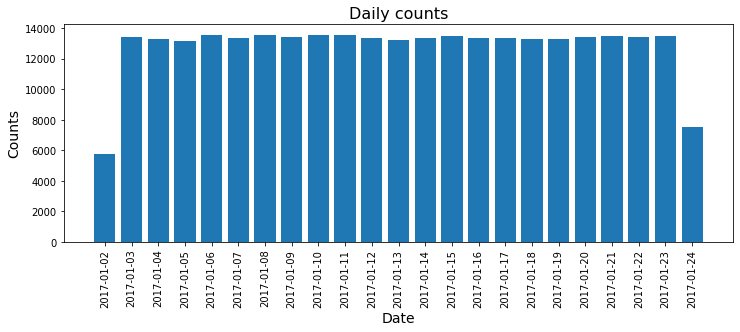

In [12]:
date = df.date.value_counts().to_frame().sort_index()

plt.figure(figsize=(12,4))
plt.xticks(rotation=90)
plt.bar(date.index, date.date)
plt.title('Daily counts', fontsize=16)
plt.ylabel('Counts', fontsize=14)
plt.xlabel('Date', fontsize=14)

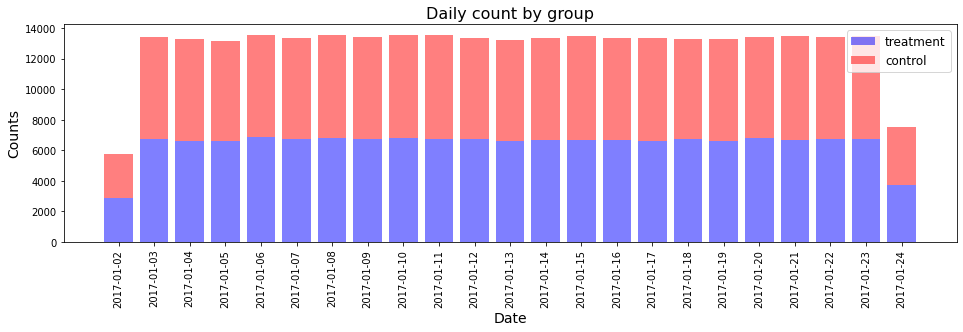

In [13]:
# divided by treatment and control
plt.figure(figsize=(16,4))

df_c = df[df['group'] == 'control'].groupby('date').count()["group"]
df_t = df[df['group'] == 'treatment'].groupby('date').count()["group"]
alpha = 0.5

p1 = plt.bar(df_c.index, df_t, color='b', alpha=alpha)
p2 = plt.bar(df_c.index, df_c, color='r', alpha=alpha, bottom=df_t) 

plt.title('Daily count by group', fontsize=16)
plt.ylabel('Counts', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(rotation=90)
plt.legend((p1[0], p2[0]), ('treatment', 'control'), fontsize=12)

plt.show()

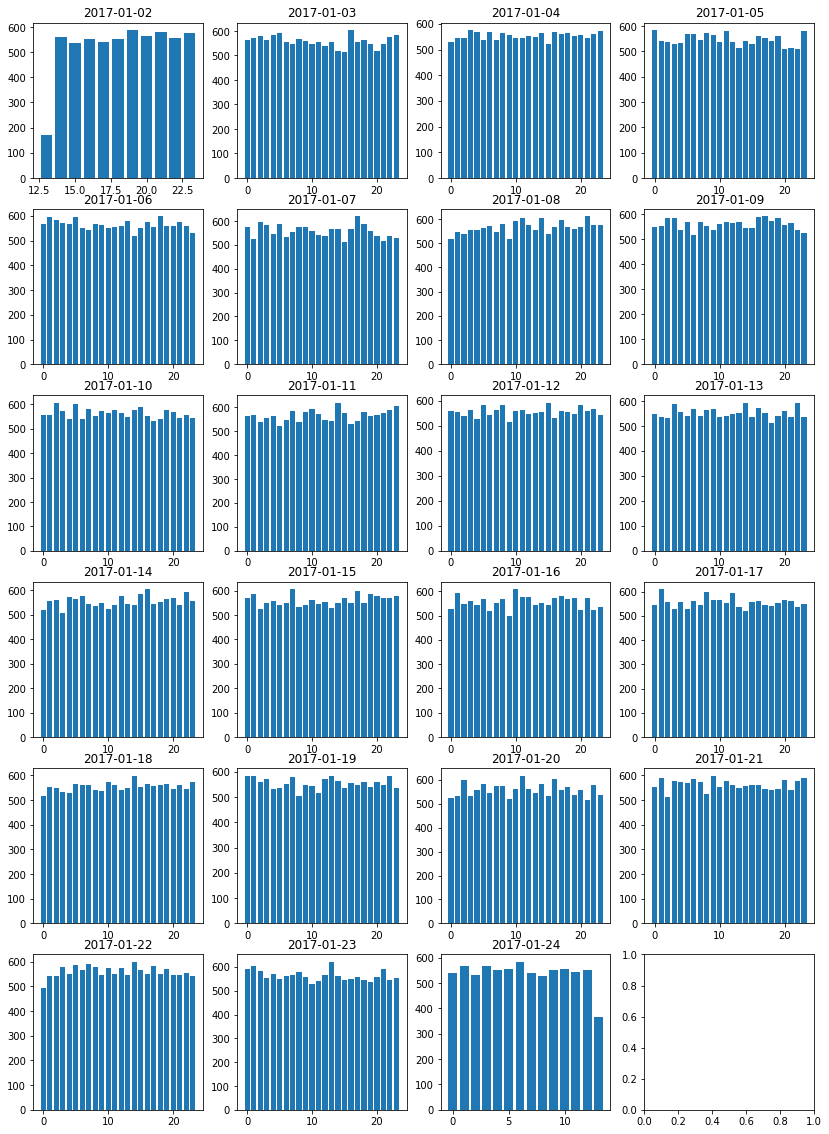

In [14]:
dt = df[['date','hour', "user_id"]].groupby(['date','hour']).count()
dt = dt.reset_index().set_index('date')

fig = plt.figure(figsize=(14,20))
axes = fig.subplots(nrows=6, ncols=4)

z = 1 

for i in dt.index.unique().tolist():
  plt.subplot(6, 4, z)
  plt.title(i)
  day_hour_user = dt[dt.index == i]
  plt.bar(day_hour_user.hour, day_hour_user.user_id)
  z = z + 1

plt.show()

It can be seen that data has been distributed around all hours for the days that have been observed. Normally there are dips on evenings (ie. sleep) - however, as this is a global dataset we can't really notice such phenomena.

Sampling

In [15]:
# obtain effective size
effect_size = sms.proportion_effectsize(0.23, 0.25) 

# sample size
sample_size = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1)

print("sample_size : ", round(sample_size)) 
print("effect_size : ", effect_size.round(5))

sample_size :  7155
effect_size :  -0.04684


In [16]:
# we check the repeating user_ids that we have identified from the beginning of the ipynb
session_counts = df['user_id'].value_counts(ascending=False) 
print(session_counts[session_counts > 1].count()," duplicated counts")

3894  duplicated counts


In [17]:
# assign duplicated users
dup_users = session_counts[session_counts > 1].count() 
dup_users_i = session_counts[session_counts > 1].index

In [18]:
# drop duplicates
df = df[~df['user_id'].isin(dup_users_i)] 

In [19]:
# sampling
c_group = df[df['group'] == 'control'].sample(n=7200, random_state=42)
t_group = df[df['group'] == 'treatment'].sample(n=7200, random_state=42)

ab_test = pd.concat([c_group, t_group], axis=0)
ab_test.reset_index(drop=True, inplace=True)

# check sampling
print("shape : ", ab_test.shape)
print("group rate :")
print(ab_test.group.value_counts(normalize=True))

shape :  (14400, 8)
group rate :
control      0.5
treatment    0.5
Name: group, dtype: float64


In [20]:
c_rate = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # std
se_p = lambda x: stats.sem(x, ddof=0)            # std_err

conversion_rates = c_rate.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std', 'std_err']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std,std_err
group,,,
control,0.116,0.321,0.004
treatment,0.118,0.323,0.004


In [24]:
ab_t(df = ab_test, g = "group", t = "converted")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



/Users/jaichung/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Cannot reject H0,0.717,A/B groups are similar
